In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nadasalem81","key":"533c66068bcc937ae5bee94405d25391"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dhruvildave/english-handwritten-characters-dataset
!unzip english-handwritten-characters-dataset.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset
License(s): ODbL-1.0
  0% 0.00/13.1M [00:00<?, ?B/s]
100% 13.1M/13.1M [00:00<00:00, 381MB/s]
unzip:  cannot find or open english-handwritten-characters-dataset.zip -d dataset, english-handwritten-characters-dataset.zip -d dataset.zip or english-handwritten-characters-dataset.zip -d dataset.ZIP.


In [ ]:
!ls

english-handwritten-characters-dataset.zip  sample_data


In [ ]:
import zipfile
import os

zip_path = "english-handwritten-characters-dataset.zip"

extract_path = "dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Decompressed", extract_path)

Decompressed dataset


In [ ]:
!ls dataset

english.csv  Img


In [ ]:
!pip install tensorflow
!pip install keras
!pip install opencv-python

In [42]:
import os
import warnings
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

# ==============================
# Ignore warnings
# ==============================
warnings.filterwarnings("ignore")

# ==============================
# Paths
# ==============================
dataset_dir = "/content/dataset"      # Dataset folder containing Img
csv_path = "/content/dataset/english.csv"  # CSV file with 'image' and 'label' columns

# ==============================
# Image parameters
# ==============================
IMG_SIZE = (32, 32)  # Small size for handwritten characters
CHANNELS = 1         # Grayscale images
BATCH_SIZE = 32

# ==============================
# Load CSV
# ==============================
df = pd.read_csv(csv_path)

# ==============================
# Load images and labels
# ==============================
images = []
labels = []

for idx, row in df.iterrows():
    # Full path to image
    img_path = os.path.join(dataset_dir, row['image'])

    # Check if image exists
    if not os.path.exists(img_path):
        print("Image not found, skipping:", img_path)
        continue

    # Open image, convert to grayscale, resize, normalize
    img = Image.open(img_path).convert("L")
    img = img.resize(IMG_SIZE)
    img = np.array(img, dtype="float32") / 255.0

    images.append(img)
    labels.append(row['label'])

# Convert to numpy array and add channel dimension
images = np.array(images)
images = images.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], CHANNELS)

# ==============================
# Encode labels to one-hot vectors
# ==============================
unique_labels = sorted(list(set(labels)))
num_classes = len(unique_labels)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
y = np.array([label_to_index[label] for label in labels])
y = np.eye(num_classes)[y]  # One-hot encoding

# ==============================
# Train / validation split
# ==============================
x_train, x_val, y_train, y_val = train_test_split(
    images, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# Data augmentation
# ==============================
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

# ==============================
# Build CNN model
# ==============================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNELS)),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(256, (3,3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ==============================
# Train model
# ==============================
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val),
    epochs=100
)

# ==============================
# Evaluate model
# ==============================
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

print("=== Final Test Evaluation ===")
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ==============================
# Save model
# ==============================
model.save("handwritten_cnn_model.keras", include_optimizer=False)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 13, 13, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,397,246 (5.33 MB)

 Trainable params: 1,397,246 (5.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.0136 - loss: 4.1381 - val_accuracy: 0.0191 - val_loss: 4.1243
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.0124 - loss: 4.1248 - val_accuracy: 0.0352 - val_loss: 3.9974
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.0400 - loss: 3.9640 - val_accuracy: 0.0968 - val_loss: 3.3936
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.0946 - loss: 3.5399 - val_accuracy: 0.2067 - val_loss: 2.9124
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.1344 - loss: 3.2067 - val_accuracy: 0.3387 - val_loss: 2.4169
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.2431 - loss: 2.7204 - val_accuracy: 0.4692 - val_loss: 1.8206
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.3154 - loss: 2.3543 - val_accuracy: 0.5689 - val_loss: 1.4210
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.4008 - loss: 1.9964 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


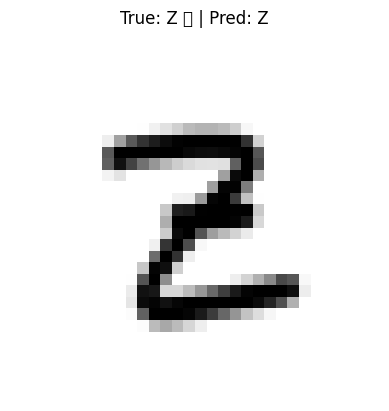

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


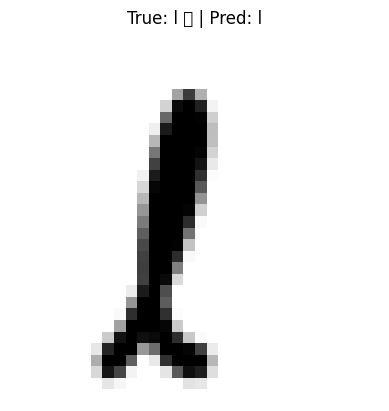

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


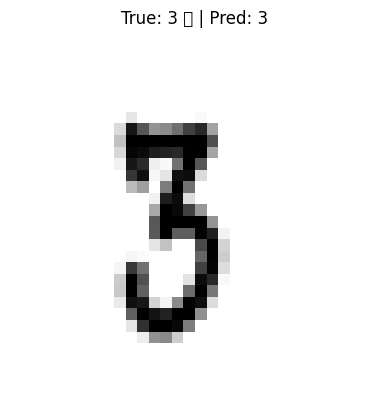

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


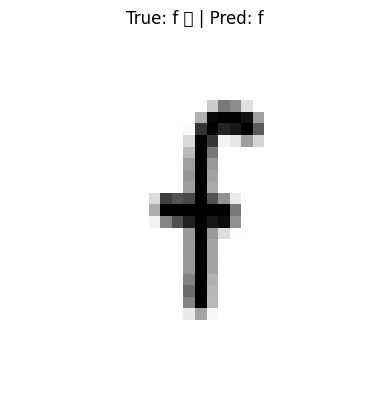

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


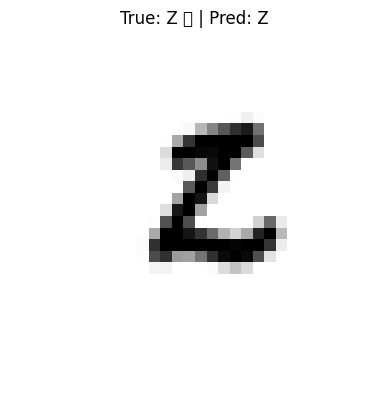

In [46]:
import random
import matplotlib.pyplot as plt

# ==============================
# Load trained model
# ==============================
from tensorflow.keras.models import load_model
model = load_model("handwritten_cnn_model.keras")

# ==============================
# Select random images from validation set
# ==============================
num_samples = 5  # Number of random images to show
indices = random.sample(range(len(x_val)), num_samples)

for idx in indices:
    img = x_val[idx]
    true_label = y_true[idx]

    # Predict label
    pred_label_idx = np.argmax(model.predict(img.reshape(1, IMG_SIZE[0], IMG_SIZE[1], CHANNELS))[0])
    pred_label = unique_labels[pred_label_idx]

    # Plot image
    plt.imshow(img.reshape(IMG_SIZE[0], IMG_SIZE[1]), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {unique_labels[true_label]} ✅ | Pred: {pred_label}")
    plt.show()